In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [ ]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Smart Retail Checkout')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
)

training_set = train_datagen.flow_from_directory(
    'Aug_Dataset/Train',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle=True
)

Found 3275 images belonging to 8 classes.


In [ ]:
test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

testing_set = test_datagen.flow_from_directory(
    'Aug_Dataset/Test',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle=False
)

Found 815 images belonging to 8 classes.


In [ ]:
images, labels = next(training_set)
labels

array([[0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 

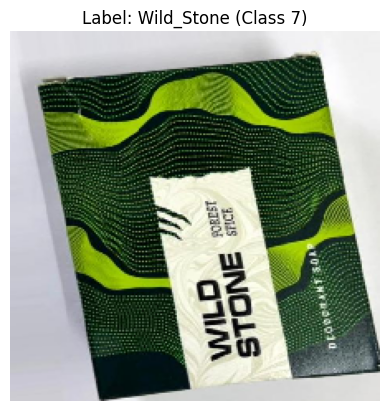

In [ ]:
image = images[7]
label_vector = labels[7]

class_index = np.argmax(label_vector)

class_names = list(training_set.class_indices.keys())

plt.imshow(image)
plt.title(f"Label: {class_names[class_index]} (Class {class_index})")
plt.axis('off')
plt.show()

In [ ]:
base_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
print(base_model.output_shape)

(None, 7, 7, 512)


In [ ]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(8, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,482,632 (101.02 MB)

 Trainable params: 6,457,480 (24.63 MB)

 Non-trainable params: 20,025,152 (76.39 MB)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
history = model.fit(
    training_set,
    validation_data=testing_set,
    epochs=15,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 2766s 27s/step - accuracy: 0.8954 - loss: 0.4001 - top_k_categorical_accuracy: 0.9730 - val_accuracy: 0.9975 - val_loss: 0.0311 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 2/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 1.0000 - loss: 0.0095 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 3.1410e-04 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 3/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - accuracy: 0.9997 - loss: 0.0044 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.0255e-04 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 4/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 28s 268ms/step - accuracy: 0.9993 - loss: 0.0037 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 5.1142e-05 - val_top_k_categorical_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 5/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 28s 268ms/step -

In [ ]:
# Load the image as PIL Image object
image = Image.open('Sample_Images/CeraVe.jpg')

# Resize image
test_image = image.resize((224, 224))

# Convert to NumPy array
test_image_arr = np.array(test_image)

# Strip alpha channel if present
if test_image_arr.ndim == 3 and test_image_arr.shape[2] == 4:
    test_image_arr = test_image_arr[:, :, :3]

# Reshape and normalize
test_inp = test_image_arr.reshape((1, 224, 224, 3)).astype('float32') / 255.0

print(test_image_arr.shape)  # Should print (224, 224, 3)

(224, 224, 3)


In [ ]:
# Assuming `training_set` variable is accessible in the notebook
classes = list(training_set.class_indices.keys())

print(f"Classes: {classes}")

Classes: ['Amul_Ice_Cream', 'Cake', 'CeraVe', 'HnS_Shampoo', 'Nestle_Milk_Powder', 'Plum', 'Thums_Up', 'Wild_Stone']


In [ ]:
# Save weights and full model to disk
model.save_weights('custom_model.weights.h5')  # Optional: save weights only
model.save('full_model.keras')  # Recommended: save entire model

In [ ]:
# Load the full saved model for inference
loaded_model = load_model('full_model.keras')

# Predict on preprocessed image
prediction = loaded_model.predict(test_inp)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
predicted_index = np.argmax(prediction)
confidence = prediction[0][predicted_index]
confidence_threshold = 0.75  # Set your acceptance threshold here

if confidence >= confidence_threshold:
    print(f"Accepted: {classes[predicted_index]} ({confidence * 100:.2f}%)")
else:
    print(f"Low Confidence: {classes[predicted_index]} ({confidence * 100:.2f}%) - Please verify manually.")

Accepted: CeraVe (91.02%)
